Define Baseline model

The data set will be devided in train - test part. Train till <2017, Test after >=2017

Calculate monthly mean for the train period

Use the monthly mean as a prediction for y_pred

Compare the y_test and y_pred using rmse metric

In [1]:
#!pip install requests
#!pip install sklearn
#!pip install statsmodels
#!pip install pmdarima

In [2]:
# Importing required libraries
import requests
import pandas as pd
import csv
import numpy as np
from itertools import permutations
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf

from pmdarima.arima import auto_arima
import statsmodels.graphics.tsaplots as tsaplot
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing

import warnings
warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.facecolor':'white'})

In [3]:
df = pd.read_csv('../Northern.csv',sep=",")
df.head()

,year_x,month_x,day_x,extent,missing,Source Data,datetime,Northern_Hemisphere,Beaufort_Sea,Chukchi_Sea,...,Sea_of_Okhotsk,Yellow_Sea,Cook_Inlet,date,day_y,month_y,year_y,timestamp,dayofyear,hour
0,1978,10,26,10.231,0.0,['/ecs/DP1/PM/NSIDC-0051.001/1978.10.26/nt_19...,1978-10-26,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1978,10,28,10.420,0.0,['/ecs/DP1/PM/NSIDC-0051.001/1978.10.28/nt_19...,1978-10-28,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1978,10,30,10.557,0.0,['/ecs/DP1/PM/NSIDC-0051.001/1978.10.30/nt_19...,1978-10-30,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1978,11,1,10.670,0.0,['/ecs/DP1/PM/NSIDC-0051.001/1978.11.01/nt_19...,1978-11-01,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1978,11,3,10.777,0.0,['/ecs/DP1/PM/NSIDC-0051.001/1978.11.03/nt_19...,1978-11-03,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d')
# Convert timestamp to datetime object
df = df.assign(
    timestamp = lambda x: pd.to_datetime(x['datetime']), 
    date = lambda x: x['timestamp'].dt.date,
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14186 entries, 0 to 14185
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   year_x                           14186 non-null  int64         
 1   month_x                          14186 non-null  int64         
 2   day_x                            14186 non-null  int64         
 3   extent                           14186 non-null  float64       
 4   missing                          14186 non-null  float64       
 5    Source Data                     14186 non-null  object        
 6   datetime                         14186 non-null  datetime64[ns]
 7   Northern_Hemisphere              5863 non-null   float64       
 8   Beaufort_Sea                     5863 non-null   float64       
 9    Chukchi_Sea                     5863 non-null   float64       
 10  East_Siberian_Sea                5863 non-null   float64  

In [5]:
#for the forecast we only need the timestamp and the extend value
df = df[['datetime', 'extent']]
print(df)
df.info()
# in the first timeperiod we only have values for every second day
# first create a DataFrame with all dates between specified start<-->end using pd.date_range()
all_dates = pd.DataFrame(pd.date_range(df['datetime'].min(), df['datetime'].max()), columns=['datetime'])
# from the all_dates DataFrame, left join onto the DataFrame with missing dates
df_model = all_dates.merge(right=df, how='left', on='datetime')
# filling the NaN values with the values of the day before
df_model.fillna(method='ffill', inplace=True)
df = df_model.reset_index(drop=True)
df.tail()
df.info()
df_arima=df

        datetime  extent
0     1978-10-26  10.231
1     1978-10-28  10.420
2     1978-10-30  10.557
3     1978-11-01  10.670
4     1978-11-03  10.777
...          ...     ...
14181 2022-03-03  14.703
14182 2022-03-04  14.748
14183 2022-03-05  14.762
14184 2022-03-06  14.756
14185 2022-03-07  14.769

[14186 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14186 entries, 0 to 14185
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  14186 non-null  datetime64[ns]
 1   extent    14186 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 221.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15839 entries, 0 to 15838
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  15839 non-null  datetime64[ns]
 1   extent    15839 non-null  float64       
dtypes: datetime64[ns](1), fl

In [6]:
# Split data into train and test set
df_base = df['extent']
train_test_split_ratio = int(len(df_base)*0.8806)
train_data, test_data = df_base[:train_test_split_ratio], df_base[train_test_split_ratio:]
df_base2 = df['datetime']
train_data_x, test_data_x = df_base2[:train_test_split_ratio], df_base2[train_test_split_ratio:]

In [7]:
df_train = pd.DataFrame({"extent":train_data,"daytime":train_data_x})
df_test = pd.DataFrame({"extent":test_data,"daytime":test_data_x})
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13947 entries, 0 to 13946
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   extent   13947 non-null  float64       
 1   daytime  13947 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 218.0 KB


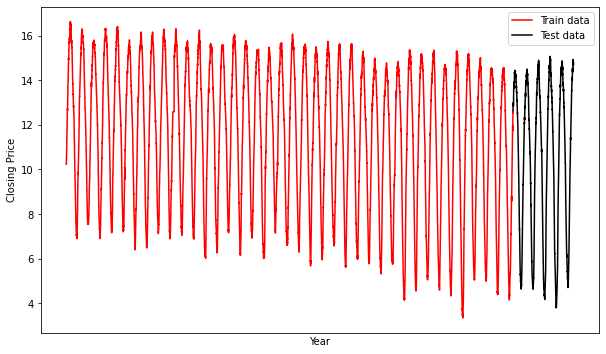

In [8]:
# Plotting the train and test set
plt.figure(figsize=(10,6))
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.xticks([])
plt.plot(train_data, 'red', label='Train data')
plt.plot(test_data, 'black', label='Test data')
plt.legend();


In [9]:
test_data_x

13947   2017-01-01
13948   2017-01-02
13949   2017-01-03
13950   2017-01-04
13951   2017-01-05
           ...    
15834   2022-03-03
15835   2022-03-04
15836   2022-03-05
15837   2022-03-06
15838   2022-03-07
Name: datetime, Length: 1892, dtype: datetime64[ns]

In [10]:
df_test=df_test.set_index([pd.Index(range(0, len(df_test.daytime)))])
df_test

,extent,daytime
0,12.643,2017-01-01
1,12.644,2017-01-02
2,12.713,2017-01-03
3,12.954,2017-01-04
4,12.956,2017-01-05
...,...,...
1887,14.703,2022-03-03
1888,14.748,2022-03-04
1889,14.762,2022-03-05
1890,14.756,2022-03-06


In [11]:
df_train['datetime'] = pd.to_datetime(df_train['daytime'], format='%Y-%m-%d')
# Convert timestamp to datetime object
df_train = df_train.assign(
    timestamp = lambda x: pd.to_datetime(x['datetime']), 
    date = lambda x: x['timestamp'].dt.date,
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day
)
df_train.month.describe()

count    13947.000000
mean         6.546067
std          3.457172
min          1.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         12.000000
Name: month, dtype: float64

In [12]:
extent_predict=df_train.groupby('month')['extent'].mean()

In [13]:
extent_predict

month
1     14.315544
2     15.203161
3     15.356752
4     14.641726
5     13.216879
6     11.656664
7      9.284650
8      6.985063
9      6.177417
10     8.120573
11    10.574912
12    12.755250
Name: extent, dtype: float64

In [14]:
df_test['datetime'] = pd.to_datetime(df_test['daytime'], format='%Y-%m-%d')
# Convert timestamp to datetime object
df_test = df_test.assign(
    timestamp = lambda x: pd.to_datetime(x['datetime']), 
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day
)
df_test.to_csv('Test.csv')

In [15]:
df_test

,extent,daytime,datetime,timestamp,year,month,day
0,12.643,2017-01-01,2017-01-01,2017-01-01,2017,1,1
1,12.644,2017-01-02,2017-01-02,2017-01-02,2017,1,2
2,12.713,2017-01-03,2017-01-03,2017-01-03,2017,1,3
3,12.954,2017-01-04,2017-01-04,2017-01-04,2017,1,4
4,12.956,2017-01-05,2017-01-05,2017-01-05,2017,1,5
...,...,...,...,...,...,...,...
1887,14.703,2022-03-03,2022-03-03,2022-03-03,2022,3,3
1888,14.748,2022-03-04,2022-03-04,2022-03-04,2022,3,4
1889,14.762,2022-03-05,2022-03-05,2022-03-05,2022,3,5
1890,14.756,2022-03-06,2022-03-06,2022-03-06,2022,3,6


In [16]:
df_obs = pd.read_csv('Test.csv')
df_obs

,Unnamed: 0,extent,daytime,datetime,timestamp,year,month,day
0,0,12.643,2017-01-01,2017-01-01,2017-01-01,2017,1,1
1,1,12.644,2017-01-02,2017-01-02,2017-01-02,2017,1,2
2,2,12.713,2017-01-03,2017-01-03,2017-01-03,2017,1,3
3,3,12.954,2017-01-04,2017-01-04,2017-01-04,2017,1,4
4,4,12.956,2017-01-05,2017-01-05,2017-01-05,2017,1,5
...,...,...,...,...,...,...,...,...
1887,1887,14.703,2022-03-03,2022-03-03,2022-03-03,2022,3,3
1888,1888,14.748,2022-03-04,2022-03-04,2022-03-04,2022,3,4
1889,1889,14.762,2022-03-05,2022-03-05,2022-03-05,2022,3,5
1890,1890,14.756,2022-03-06,2022-03-06,2022-03-06,2022,3,6


In [17]:
#data_month = df_train.resample('M', on='month').mean()
#df_pred =[df_test['datetime'],df_test['year'],df_test['month'], df_test['day'],df_test['extent']]
for months in range(1,13):
    for ind in range(0,len(df_test['month'])):
        if df_test['month'][ind]==months:
           # print(ind, df_test['extent'][ind],extent_predict[months])
           #df_test['extent'][i] = extent_predict[months]
           #print(df_test['extent'][i], extent_predict[months])
            df_test['extent'][ind] = extent_predict[months]
           



In [18]:
df_test

,extent,daytime,datetime,timestamp,year,month,day
0,14.315544,2017-01-01,2017-01-01,2017-01-01,2017,1,1
1,14.315544,2017-01-02,2017-01-02,2017-01-02,2017,1,2
2,14.315544,2017-01-03,2017-01-03,2017-01-03,2017,1,3
3,14.315544,2017-01-04,2017-01-04,2017-01-04,2017,1,4
4,14.315544,2017-01-05,2017-01-05,2017-01-05,2017,1,5
...,...,...,...,...,...,...,...
1887,15.356752,2022-03-03,2022-03-03,2022-03-03,2022,3,3
1888,15.356752,2022-03-04,2022-03-04,2022-03-04,2022,3,4
1889,15.356752,2022-03-05,2022-03-05,2022-03-05,2022,3,5
1890,15.356752,2022-03-06,2022-03-06,2022-03-06,2022,3,6


In [19]:
extent_predict

month
1     14.315544
2     15.203161
3     15.356752
4     14.641726
5     13.216879
6     11.656664
7      9.284650
8      6.985063
9      6.177417
10     8.120573
11    10.574912
12    12.755250
Name: extent, dtype: float64

In [20]:
df_test

,extent,daytime,datetime,timestamp,year,month,day
0,14.315544,2017-01-01,2017-01-01,2017-01-01,2017,1,1
1,14.315544,2017-01-02,2017-01-02,2017-01-02,2017,1,2
2,14.315544,2017-01-03,2017-01-03,2017-01-03,2017,1,3
3,14.315544,2017-01-04,2017-01-04,2017-01-04,2017,1,4
4,14.315544,2017-01-05,2017-01-05,2017-01-05,2017,1,5
...,...,...,...,...,...,...,...
1887,15.356752,2022-03-03,2022-03-03,2022-03-03,2022,3,3
1888,15.356752,2022-03-04,2022-03-04,2022-03-04,2022,3,4
1889,15.356752,2022-03-05,2022-03-05,2022-03-05,2022,3,5
1890,15.356752,2022-03-06,2022-03-06,2022-03-06,2022,3,6


In [21]:
df_test['extent']

0       14.315544
1       14.315544
2       14.315544
3       14.315544
4       14.315544
          ...    
1887    15.356752
1888    15.356752
1889    15.356752
1890    15.356752
1891    15.356752
Name: extent, Length: 1892, dtype: float64

In [22]:
df_test

,extent,daytime,datetime,timestamp,year,month,day
0,14.315544,2017-01-01,2017-01-01,2017-01-01,2017,1,1
1,14.315544,2017-01-02,2017-01-02,2017-01-02,2017,1,2
2,14.315544,2017-01-03,2017-01-03,2017-01-03,2017,1,3
3,14.315544,2017-01-04,2017-01-04,2017-01-04,2017,1,4
4,14.315544,2017-01-05,2017-01-05,2017-01-05,2017,1,5
...,...,...,...,...,...,...,...
1887,15.356752,2022-03-03,2022-03-03,2022-03-03,2022,3,3
1888,15.356752,2022-03-04,2022-03-04,2022-03-04,2022,3,4
1889,15.356752,2022-03-05,2022-03-05,2022-03-05,2022,3,5
1890,15.356752,2022-03-06,2022-03-06,2022-03-06,2022,3,6


In [23]:
df_obs = pd.read_csv('Test.csv')

In [24]:
df_obs

,Unnamed: 0,extent,daytime,datetime,timestamp,year,month,day
0,0,12.643,2017-01-01,2017-01-01,2017-01-01,2017,1,1
1,1,12.644,2017-01-02,2017-01-02,2017-01-02,2017,1,2
2,2,12.713,2017-01-03,2017-01-03,2017-01-03,2017,1,3
3,3,12.954,2017-01-04,2017-01-04,2017-01-04,2017,1,4
4,4,12.956,2017-01-05,2017-01-05,2017-01-05,2017,1,5
...,...,...,...,...,...,...,...,...
1887,1887,14.703,2022-03-03,2022-03-03,2022-03-03,2022,3,3
1888,1888,14.748,2022-03-04,2022-03-04,2022-03-04,2022,3,4
1889,1889,14.762,2022-03-05,2022-03-05,2022-03-05,2022,3,5
1890,1890,14.756,2022-03-06,2022-03-06,2022-03-06,2022,3,6


In [25]:
df_obs['datetime'] = pd.to_datetime(df_obs['daytime'], format='%Y-%m-%d')
# Convert timestamp to datetime object
df_obs = df_obs.assign(
    timestamp = lambda x: pd.to_datetime(x['datetime']), 
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day
)


In [26]:
df_obs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1892 entries, 0 to 1891
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  1892 non-null   int64         
 1   extent      1892 non-null   float64       
 2   daytime     1892 non-null   object        
 3   datetime    1892 non-null   datetime64[ns]
 4   timestamp   1892 non-null   datetime64[ns]
 5   year        1892 non-null   int64         
 6   month       1892 non-null   int64         
 7   day         1892 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(1)
memory usage: 118.4+ KB


In [27]:
df_obs

,Unnamed: 0,extent,daytime,datetime,timestamp,year,month,day
0,0,12.643,2017-01-01,2017-01-01,2017-01-01,2017,1,1
1,1,12.644,2017-01-02,2017-01-02,2017-01-02,2017,1,2
2,2,12.713,2017-01-03,2017-01-03,2017-01-03,2017,1,3
3,3,12.954,2017-01-04,2017-01-04,2017-01-04,2017,1,4
4,4,12.956,2017-01-05,2017-01-05,2017-01-05,2017,1,5
...,...,...,...,...,...,...,...,...
1887,1887,14.703,2022-03-03,2022-03-03,2022-03-03,2022,3,3
1888,1888,14.748,2022-03-04,2022-03-04,2022-03-04,2022,3,4
1889,1889,14.762,2022-03-05,2022-03-05,2022-03-05,2022,3,5
1890,1890,14.756,2022-03-06,2022-03-06,2022-03-06,2022,3,6


In [28]:
df_test

,extent,daytime,datetime,timestamp,year,month,day
0,14.315544,2017-01-01,2017-01-01,2017-01-01,2017,1,1
1,14.315544,2017-01-02,2017-01-02,2017-01-02,2017,1,2
2,14.315544,2017-01-03,2017-01-03,2017-01-03,2017,1,3
3,14.315544,2017-01-04,2017-01-04,2017-01-04,2017,1,4
4,14.315544,2017-01-05,2017-01-05,2017-01-05,2017,1,5
...,...,...,...,...,...,...,...
1887,15.356752,2022-03-03,2022-03-03,2022-03-03,2022,3,3
1888,15.356752,2022-03-04,2022-03-04,2022-03-04,2022,3,4
1889,15.356752,2022-03-05,2022-03-05,2022-03-05,2022,3,5
1890,15.356752,2022-03-06,2022-03-06,2022-03-06,2022,3,6


In [ ]:
df_obs.extent

0       12.643
1       12.644
2       12.713
3       12.954
4       12.956
         ...  
1887    14.703
1888    14.748
1889    14.762
1890    14.756
1891    14.769
Name: extent, Length: 1892, dtype: float64

In [ ]:
#df_obs.set_index([pd.Index(range(0, len(df_obs.extent)))])
#df_obs.extent

In [ ]:
#df_test=df_test.set_index([pd.Index(range(0, len(df_test.month)))])
#df_test.extent

In [ ]:
rmse_baseline = sqrt(mean_squared_error(df_obs.extent, df_test.extent))
print("Baseline RMSE : " + str(round(rmse_baseline,3)))

Baseline RMSE : 1.361


Baselinmodel for city of okhotsk

In [137]:
df_masie = pd.read_csv('Ochotsk.csv',sep=",")
df_masie.head()

,datetime,Sea_of_Okhotsk
0,2006-01-01,287369.54
1,2006-01-02,287369.54
2,2006-01-03,311943.21
3,2006-01-04,372868.02
4,2006-01-05,363515.34


In [139]:
df_masie['datetime'] = pd.to_datetime(df_masie['datetime'], format='%Y-%m-%d')
# Convert timestamp to datetime object
df_masie = df_masie.assign(
    timestamp = lambda x: pd.to_datetime(x['datetime']), 
    date = lambda x: x['timestamp'].dt.date,
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day
)
df_masie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5865 entries, 0 to 5864
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        5865 non-null   datetime64[ns]
 1   Sea_of_Okhotsk  5865 non-null   float64       
 2   timestamp       5865 non-null   datetime64[ns]
 3   date            5865 non-null   object        
 4   year            5865 non-null   int64         
 5   month           5865 non-null   int64         
 6   day             5865 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(3), object(1)
memory usage: 320.9+ KB


In [160]:
# Split data into train and test set
df_ochotsk = df_masie['Sea_of_Okhotsk']
train_test_split_ratio_2 = int(len(df_ochotsk)*0.8023)
train_data_2, test_data_2 = df_ochotsk[:train_test_split_ratio_2], df_ochotsk[train_test_split_ratio_2:]
df_base2 = df_masie['datetime']
train_data_x_2, test_data_x_2 = df_base2[:train_test_split_ratio_2], df_base2[train_test_split_ratio_2:]


In [161]:
df_ochotsk[:train_test_split_ratio_2]

0       287369.54
1       287369.54
2       311943.21
3       372868.02
4       363515.34
          ...    
4700    302094.74
4701    282975.67
4702    258814.71
4703    281330.78
4704    347016.16
Name: Sea_of_Okhotsk, Length: 4705, dtype: float64

In [163]:
df_train_2 = pd.DataFrame({"extent":train_data_2,"daytime":train_data_x_2})
df_test_2 = pd.DataFrame({"extent":test_data_2,"daytime":test_data_x_2})
test_data_2
train_data_2

0       287369.54
1       287369.54
2       311943.21
3       372868.02
4       363515.34
          ...    
4700    302094.74
4701    282975.67
4702    258814.71
4703    281330.78
4704    347016.16
Name: Sea_of_Okhotsk, Length: 4705, dtype: float64

In [168]:
df_train_2

,extent,daytime
0,287369.54,2006-01-01
1,287369.54,2006-01-02
2,311943.21,2006-01-03
3,372868.02,2006-01-04
4,363515.34,2006-01-05
...,...,...
4700,302094.74,2018-12-27
4701,282975.67,2018-12-28
4702,258814.71,2018-12-29
4703,281330.78,2018-12-30


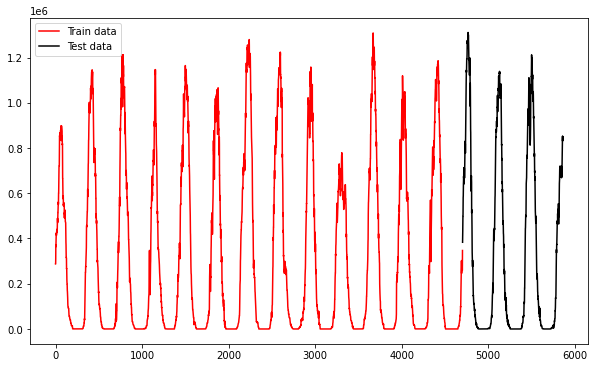

In [166]:
# Plotting the train and test set
plt.figure(figsize=(10,6))
plt.plot(train_data_2, 'red', label='Train data')
plt.plot(test_data_2, 'black', label='Test data')
plt.legend();


In [170]:
df_train_2['datetime'] = pd.to_datetime(df_train_2['daytime'], format='%Y-%m-%d')
# Convert timestamp to datetime object
df_train_2 = df_train_2.assign(
    timestamp = lambda x: pd.to_datetime(x['datetime']), 
    date = lambda x: x['timestamp'].dt.date,
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day
)
df_train_2.month.describe()

count    4705.000000
mean        6.525824
std         3.448575
min         1.000000
25%         4.000000
50%         7.000000
75%        10.000000
max        12.000000
Name: month, dtype: float64

In [172]:
extent_predict_2=df_train_2.groupby('month')['extent'].mean()
extent_predict_2

month
1     615708.953008
2     935924.210274
3     970361.606559
4     625617.951034
5     210435.762960
6      41938.715696
7       4220.348650
8        111.781197
9         18.688553
10       454.720677
11     23528.285788
12    227073.673960
Name: extent, dtype: float64

In [173]:
df_test_2['datetime'] = pd.to_datetime(df_test_2['daytime'], format='%Y-%m-%d')
# Convert timestamp to datetime object
df_test_2 = df_test_2.assign(
    timestamp = lambda x: pd.to_datetime(x['datetime']), 
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day
)
df_test_2.to_csv('Test_2.csv')

In [174]:
df_test_2

,extent,daytime,datetime,timestamp,year,month,day
4705,383311.12,2019-01-01,2019-01-01,2019-01-01,2019,1,1
4706,399001.58,2019-01-02,2019-01-02,2019-01-02,2019,1,2
4707,431604.83,2019-01-03,2019-01-03,2019-01-03,2019,1,3
4708,484231.82,2019-01-04,2019-01-04,2019-01-04,2019,1,4
4709,497660.19,2019-01-05,2019-01-05,2019-01-05,2019,1,5
...,...,...,...,...,...,...,...
5860,852270.56,2022-03-01,2022-03-01,2022-03-01,2022,3,1
5861,830634.94,2022-03-02,2022-03-02,2022-03-02,2022,3,2
5862,848778.54,2022-03-03,2022-03-03,2022-03-03,2022,3,3
5863,851531.97,2022-03-04,2022-03-04,2022-03-04,2022,3,4


In [175]:
df_obs_2 = pd.read_csv('Test_2.csv')
df_obs_2

,Unnamed: 0,extent,daytime,datetime,timestamp,year,month,day
0,4705,383311.12,2019-01-01,2019-01-01,2019-01-01,2019,1,1
1,4706,399001.58,2019-01-02,2019-01-02,2019-01-02,2019,1,2
2,4707,431604.83,2019-01-03,2019-01-03,2019-01-03,2019,1,3
3,4708,484231.82,2019-01-04,2019-01-04,2019-01-04,2019,1,4
4,4709,497660.19,2019-01-05,2019-01-05,2019-01-05,2019,1,5
...,...,...,...,...,...,...,...,...
1155,5860,852270.56,2022-03-01,2022-03-01,2022-03-01,2022,3,1
1156,5861,830634.94,2022-03-02,2022-03-02,2022-03-02,2022,3,2
1157,5862,848778.54,2022-03-03,2022-03-03,2022-03-03,2022,3,3
1158,5863,851531.97,2022-03-04,2022-03-04,2022-03-04,2022,3,4


In [178]:
df_test_2=df_test_2.set_index([pd.Index(range(0, len(df_test_2.daytime)))])

In [179]:
#data_month = df_train.resample('M', on='month').mean()
#df_pred =[df_test['datetime'],df_test['year'],df_test['month'], df_test['day'],df_test['extent']]
for months in range(1,13):
    for ind in range(0,len(df_test_2['month'])):
        if df_test_2['month'][ind]==months:
           # print(ind, df_test['extent'][ind],extent_predict[months])
           #df_test['extent'][i] = extent_predict[months]
           #print(df_test['extent'][i], extent_predict[months])
            df_test_2['extent'][ind] = extent_predict_2[months]

In [180]:
rmse_baseline_2 = sqrt(mean_squared_error(df_obs_2.extent, df_test_2.extent))
print("Baseline RMSE : " + str(round(rmse_baseline_2,3)))

Baseline RMSE : 121682.296


In [219]:
df_obs_2['datetime'] = pd.to_datetime(df_obs_2['daytime'], format='%Y-%m-%d')
# Convert timestamp to datetime object
df_obs_2 = df_obs_2.assign(
    timestamp = lambda x: pd.to_datetime(x['datetime']), 
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day
)

In [196]:
plt.style.use('seaborn-darkgrid')
font = {'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)
plt.rcParams['axes.labelweight'] = 'bold'

In [221]:
df_obs_2

,Unnamed: 0,extent,daytime,datetime,timestamp,year,month,day
0,4705,383311.12,2019-01-01,2019-01-01,2019-01-01,2019,1,1
1,4706,399001.58,2019-01-02,2019-01-02,2019-01-02,2019,1,2
2,4707,431604.83,2019-01-03,2019-01-03,2019-01-03,2019,1,3
3,4708,484231.82,2019-01-04,2019-01-04,2019-01-04,2019,1,4
4,4709,497660.19,2019-01-05,2019-01-05,2019-01-05,2019,1,5
...,...,...,...,...,...,...,...,...
1155,5860,852270.56,2022-03-01,2022-03-01,2022-03-01,2022,3,1
1156,5861,830634.94,2022-03-02,2022-03-02,2022-03-02,2022,3,2
1157,5862,848778.54,2022-03-03,2022-03-03,2022-03-03,2022,3,3
1158,5863,851531.97,2022-03-04,2022-03-04,2022-03-04,2022,3,4


In [222]:
df_obs_2.year

0       2019
1       2019
2       2019
3       2019
4       2019
        ... 
1155    2022
1156    2022
1157    2022
1158    2022
1159    2022
Name: year, Length: 1160, dtype: int64

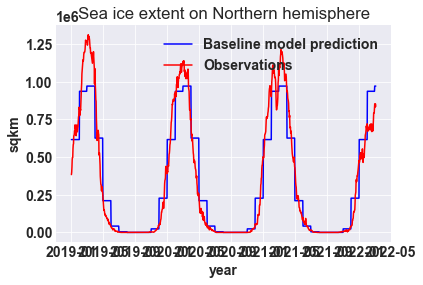

In [226]:
#comparing daily data with monthly data
import matplotlib.pyplot as plt
plt.plot(df_test_2['daytime'], df_test_2['extent'], 'b', df_obs_2['datetime'], df_obs_2['extent'], 'r')
plt.legend(['Baseline model prediction', 'Observations'])
plt.figsize=(8,8)

plt.gca().update(dict(title='Sea ice extent on Northern hemisphere', xlabel='year', ylabel=r'sqkm'))
plt.savefig('baseline_2.png')

In [ ]:
# Split data into train and test set
df_base = df['extent']
train_test_split_ratio = int(len(df_base)*0.8806)
train_data, test_data = df_base[:train_test_split_ratio], df_base[train_test_split_ratio:]
df_base2 = df['datetime']
train_data_x, test_data_x = df_base2[:train_test_split_ratio], df_base2[train_test_split_ratio:]

In [ ]:
df_test

,extent,daytime,datetime,timestamp,year,month,day
0,14.315544,2017-01-01,2017-01-01,2017-01-01,2017,1,1
1,14.315544,2017-01-02,2017-01-02,2017-01-02,2017,1,2
2,14.315544,2017-01-03,2017-01-03,2017-01-03,2017,1,3
3,14.315544,2017-01-04,2017-01-04,2017-01-04,2017,1,4
4,14.315544,2017-01-05,2017-01-05,2017-01-05,2017,1,5
...,...,...,...,...,...,...,...
1887,15.356752,2022-03-03,2022-03-03,2022-03-03,2022,3,3
1888,15.356752,2022-03-04,2022-03-04,2022-03-04,2022,3,4
1889,15.356752,2022-03-05,2022-03-05,2022-03-05,2022,3,5
1890,15.356752,2022-03-06,2022-03-06,2022-03-06,2022,3,6


In [ ]:
df_obs['timestamp']

0      2017-01-01
1      2017-01-02
2      2017-01-03
3      2017-01-04
4      2017-01-05
          ...    
1887   2022-03-03
1888   2022-03-04
1889   2022-03-05
1890   2022-03-06
1891   2022-03-07
Name: timestamp, Length: 1892, dtype: datetime64[ns]

In [ ]:
df_obs['extent']

0       12.643
1       12.644
2       12.713
3       12.954
4       12.956
         ...  
1887    14.703
1888    14.748
1889    14.762
1890    14.756
1891    14.769
Name: extent, Length: 1892, dtype: float64

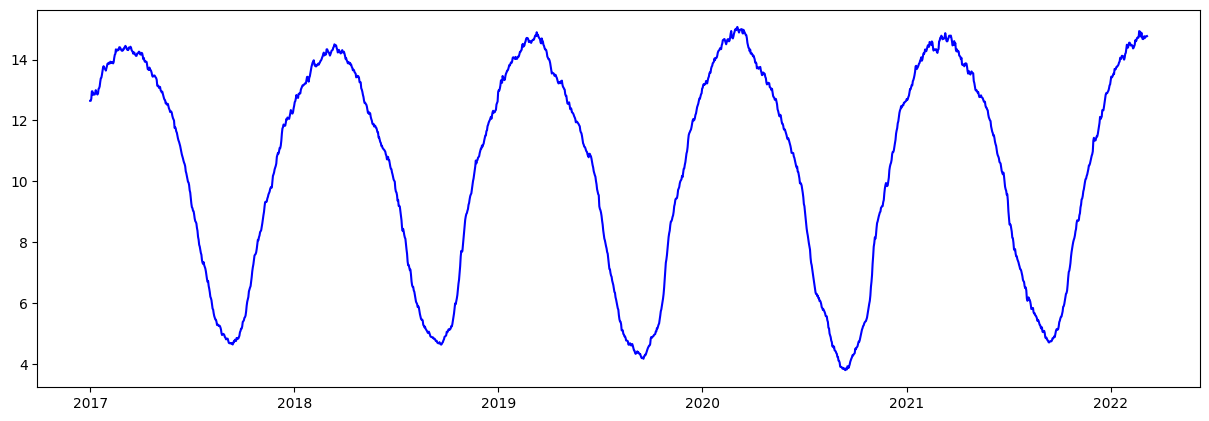

In [ ]:
#comparing daily data with monthly data
plt.plot(df_obs['timestamp'], df_obs['extent'], 'b');
#legend!

In [ ]:
df_test

,extent,daytime,datetime,timestamp,year,month,day
0,14.315544,2017-01-01,2017-01-01,2017-01-01,2017,1,1
1,14.315544,2017-01-02,2017-01-02,2017-01-02,2017,1,2
2,14.315544,2017-01-03,2017-01-03,2017-01-03,2017,1,3
3,14.315544,2017-01-04,2017-01-04,2017-01-04,2017,1,4
4,14.315544,2017-01-05,2017-01-05,2017-01-05,2017,1,5
...,...,...,...,...,...,...,...
1887,15.356752,2022-03-03,2022-03-03,2022-03-03,2022,3,3
1888,15.356752,2022-03-04,2022-03-04,2022-03-04,2022,3,4
1889,15.356752,2022-03-05,2022-03-05,2022-03-05,2022,3,5
1890,15.356752,2022-03-06,2022-03-06,2022-03-06,2022,3,6


In [ ]:
df_obs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1892 entries, 0 to 1891
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  1892 non-null   int64         
 1   extent      1892 non-null   float64       
 2   daytime     1892 non-null   object        
 3   datetime    1892 non-null   datetime64[ns]
 4   timestamp   1892 non-null   datetime64[ns]
 5   year        1892 non-null   int64         
 6   month       1892 non-null   int64         
 7   day         1892 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(1)
memory usage: 118.4+ KB


<AxesSubplot:xlabel='timestamp'>

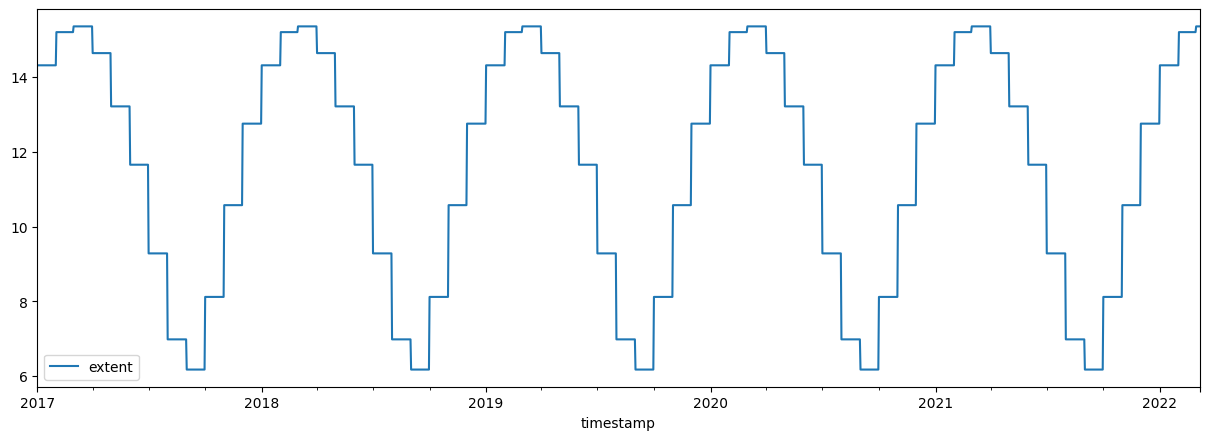

In [ ]:
df_test.plot(x='timestamp', y='extent')

In [46]:
from numpy import*
import matplotlib.pyplot as plt
X = linspace(-pi, pi, 1000)

class Crtaj:

    def nacrtaj(self,x,y):
         self.x=x
         self.y=y
         return plt.plot (x,y,"om")

def oznaci(self):
    return plt.xlabel("x-os"), plt.ylabel("y-os"), plt.grid(b=True)

In [ ]:
import matplotlib.pyplot as plt
plt.scatter([1,2,3,4,5,6],[3,5,3,2,4,7])
plt.gca().update(dict(title='SCATTER', xlabel='x', ylabel='y', ylim=(0,10)))

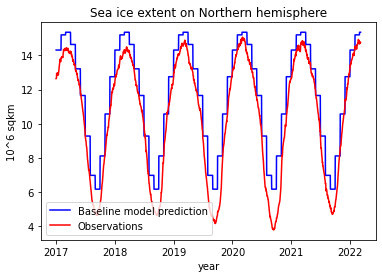

In [51]:
#comparing daily data with monthly data
import matplotlib.pyplot as plt
plt.plot(df_test['timestamp'], df_test['extent'], 'b', df_obs['timestamp'], df_obs['extent'], 'r')
plt.legend(['Baseline model prediction', 'Observations'])
plt.gca().update(dict(title='Sea ice extent on Northern hemisphere', xlabel='year', ylabel=r'10^6 sqkm'))
plt.savefig('baseline.png')

## Modelling with prophet

In [ ]:
#!pip install fbprophet

In [ ]:
# check prophet version
import fbprophet
from fbprophet import Prophet
# print version number
print('Prophet %s' % fbprophet.__version__)

Prophet 0.7.1


In [ ]:
df_obs["ds"] = df_obs.timestamp
df_obs["y"] = df_obs.extent

In [52]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(df_obs[["ds", "y"]])
future = m.make_future_dataframe(periods=300)
forecast = m.predict(future)

NameError: name 'Prophet' is not defined

In [ ]:
# define the model
model = Prophet()
df.columns = ['ds', 'y']
# fit the model
model.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -448.399


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       50679.6    0.00190631       3777.87           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       50779.4      0.012767       691.639           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       50925.1      0.014344         30240           1           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       51002.4     0.0117461        4507.8           1           1      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       51057.4     0.0232312       4465.99      0.6778     0.06778      581   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

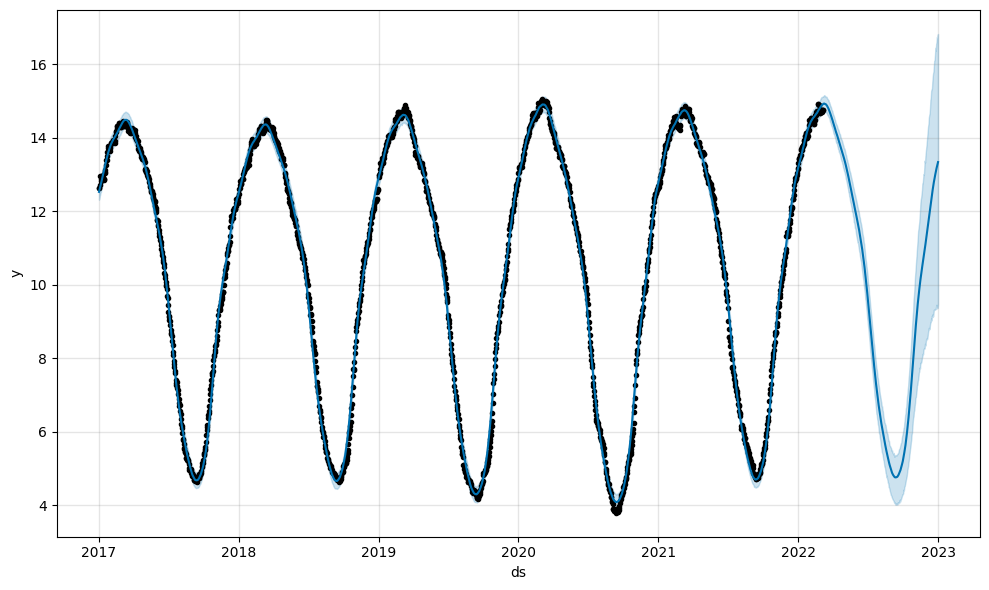

In [ ]:
fig1 = m.plot(forecast)

In [ ]:
df_train["ds"] = df_train.timestamp
df_train["y"] = df_train.extent

In [ ]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(df_train[["ds", "y"]])
future = m.make_future_dataframe(periods=365*140)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -299.133
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       42216.2    0.00211683        5100.2      0.1052      0.1052      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       42278.3   0.000879411       1710.85      0.4836      0.4836      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       42320.6    0.00500569       1216.98           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       42349.1     0.0113511       3683.83           1           1      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       42356.6    0.00420674       1271.74           1           1      574   
    Iter      log prob        ||dx||      ||grad||       alpha  

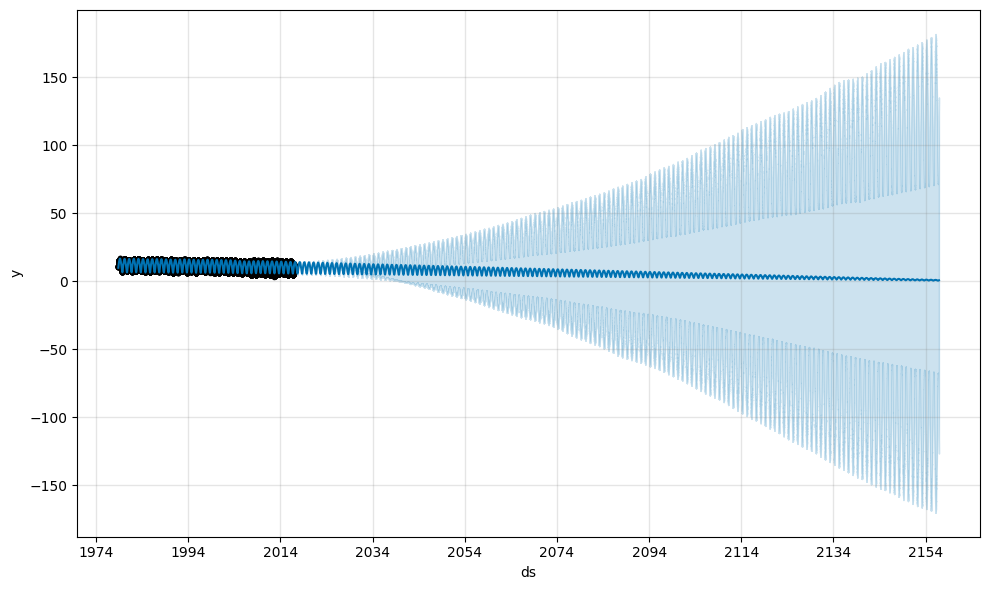

In [ ]:
fig1 = m.plot(forecast)

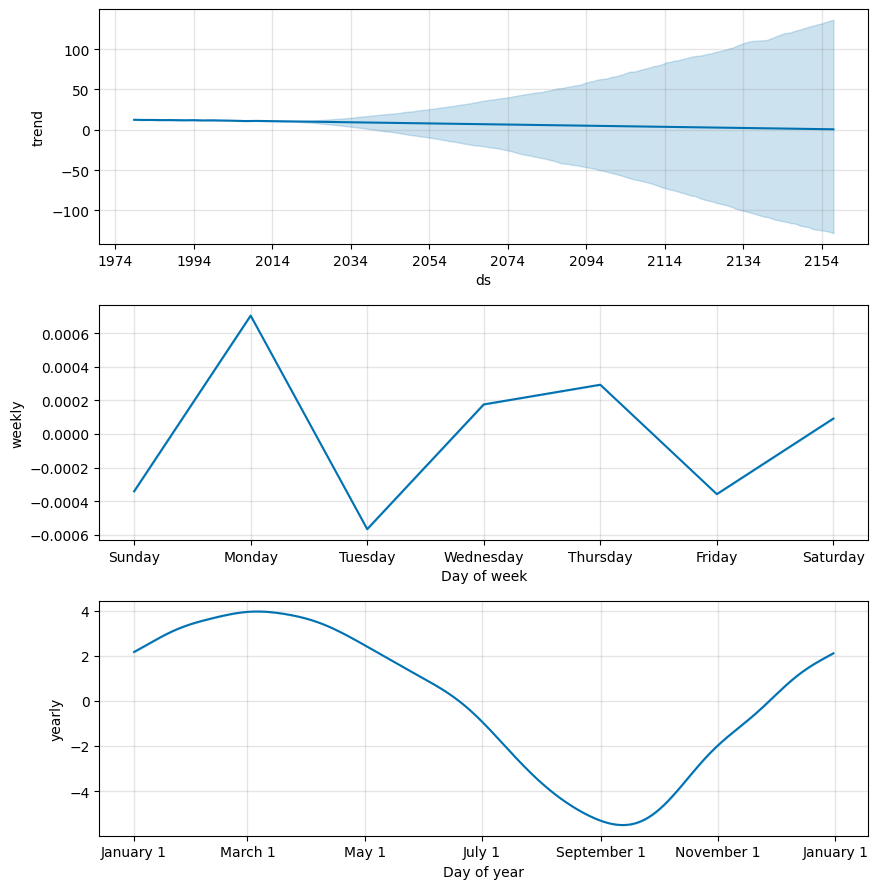

In [ ]:
model.plot_components(forecast);

## Time series analysis

In [ ]:
# Importing required libraries
import requests
import pandas as pd
import csv
import numpy as np
from itertools import permutations
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf

from pmdarima.arima import auto_arima
import statsmodels.graphics.tsaplots as tsaplot
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing

import warnings
warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.facecolor':'white'})

In [ ]:
# Define plotting parameters and custom color palette 
cmaps_hex = ['#193251','#FF5A36','#1E4485', '#99D04A','#FF5A36', '#DB6668']
#sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

In [ ]:
df = pd.read_csv('../Northern.csv', index_col='datetime')
df.head()

,year_x,month_x,day_x,extent,missing,Source Data,Northern_Hemisphere,Beaufort_Sea,Chukchi_Sea,East_Siberian_Sea,...,Sea_of_Okhotsk,Yellow_Sea,Cook_Inlet,date,day_y,month_y,year_y,timestamp,dayofyear,hour
datetime,,,,,,,,,,,,,,,,,,,,,
1978-10-26,1978,10,26,10.231,0.0,['/ecs/DP1/PM/NSIDC-0051.001/1978.10.26/nt_19...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1978-10-28,1978,10,28,10.420,0.0,['/ecs/DP1/PM/NSIDC-0051.001/1978.10.28/nt_19...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1978-10-30,1978,10,30,10.557,0.0,['/ecs/DP1/PM/NSIDC-0051.001/1978.10.30/nt_19...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1978-11-01,1978,11,1,10.670,0.0,['/ecs/DP1/PM/NSIDC-0051.001/1978.11.01/nt_19...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1978-11-03,1978,11,3,10.777,0.0,['/ecs/DP1/PM/NSIDC-0051.001/1978.11.03/nt_19...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


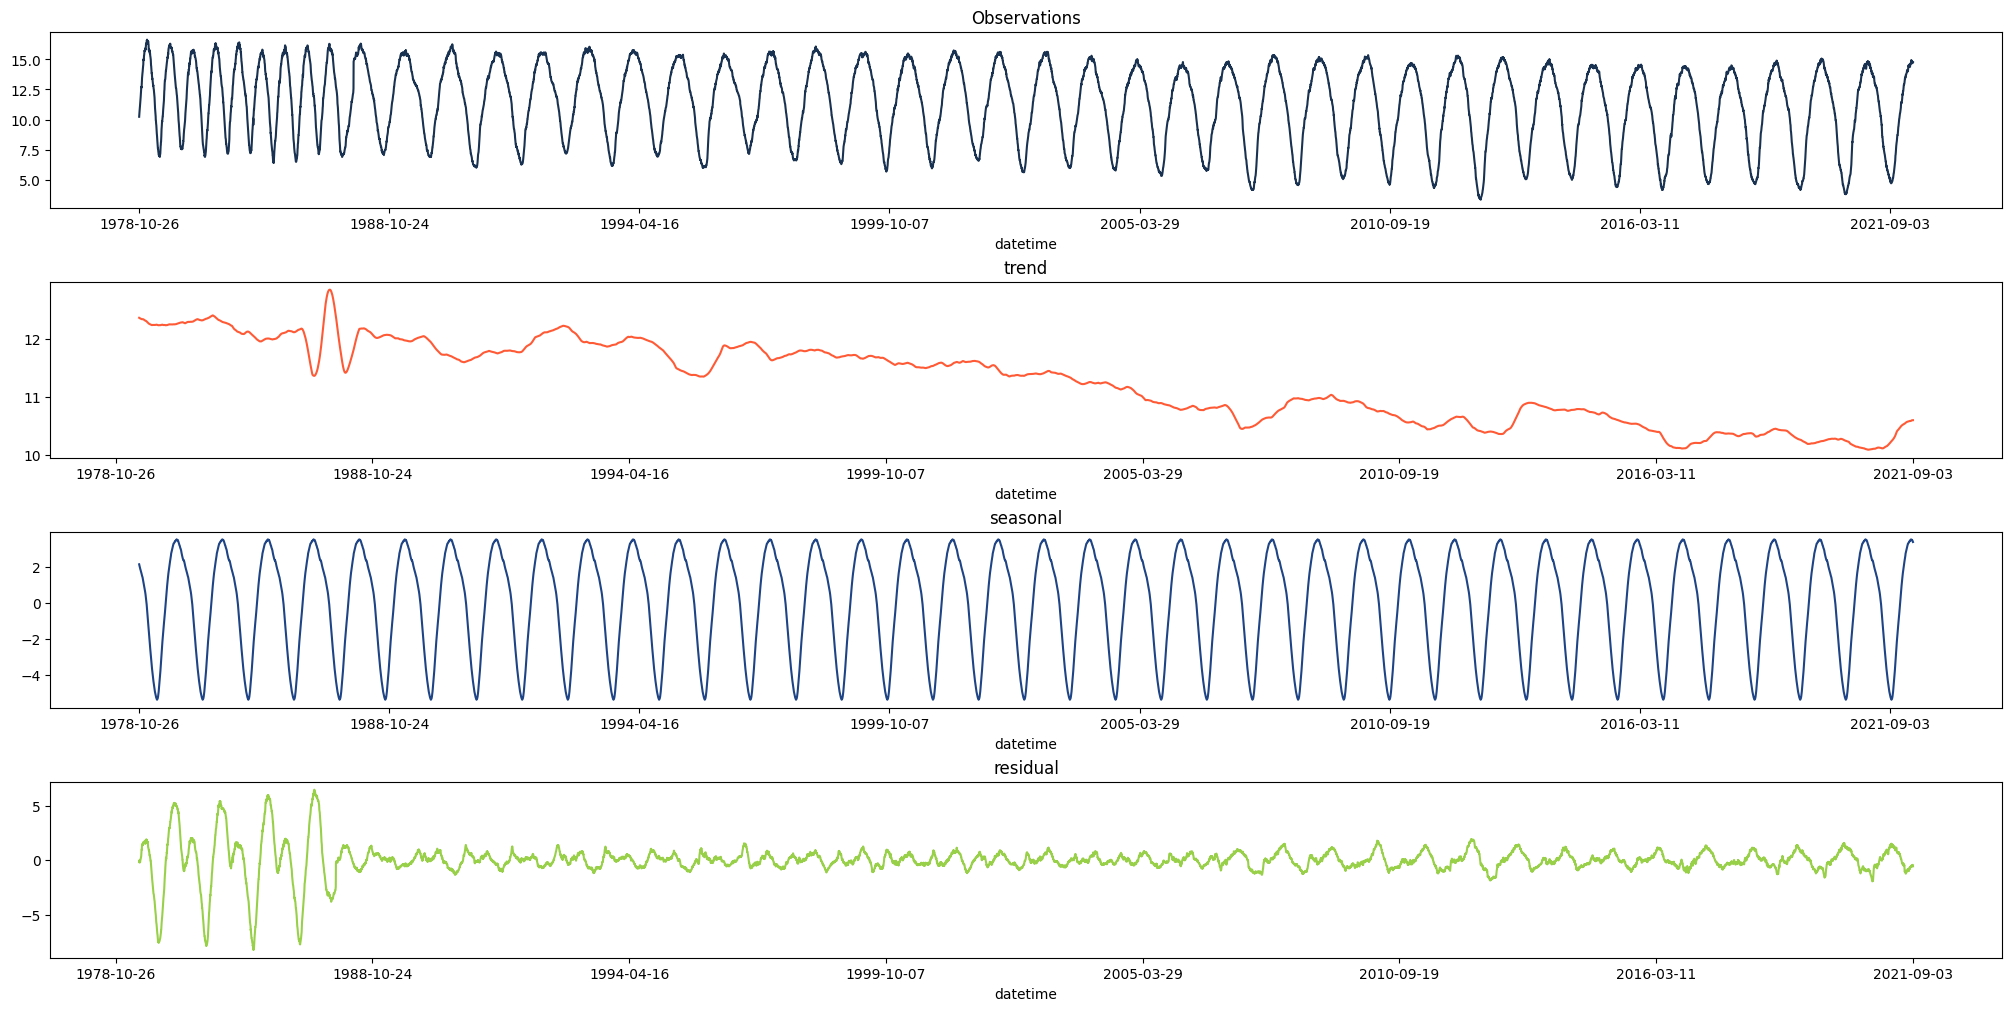

In [ ]:
# Check decomposition of trend, seasonality and residue of original time series
decomposition = seasonal_decompose(x=df['extent'], 
                                   model='additive',
                                   period=365)


fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='Observations')
decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')
fig.set_size_inches(20, 10);

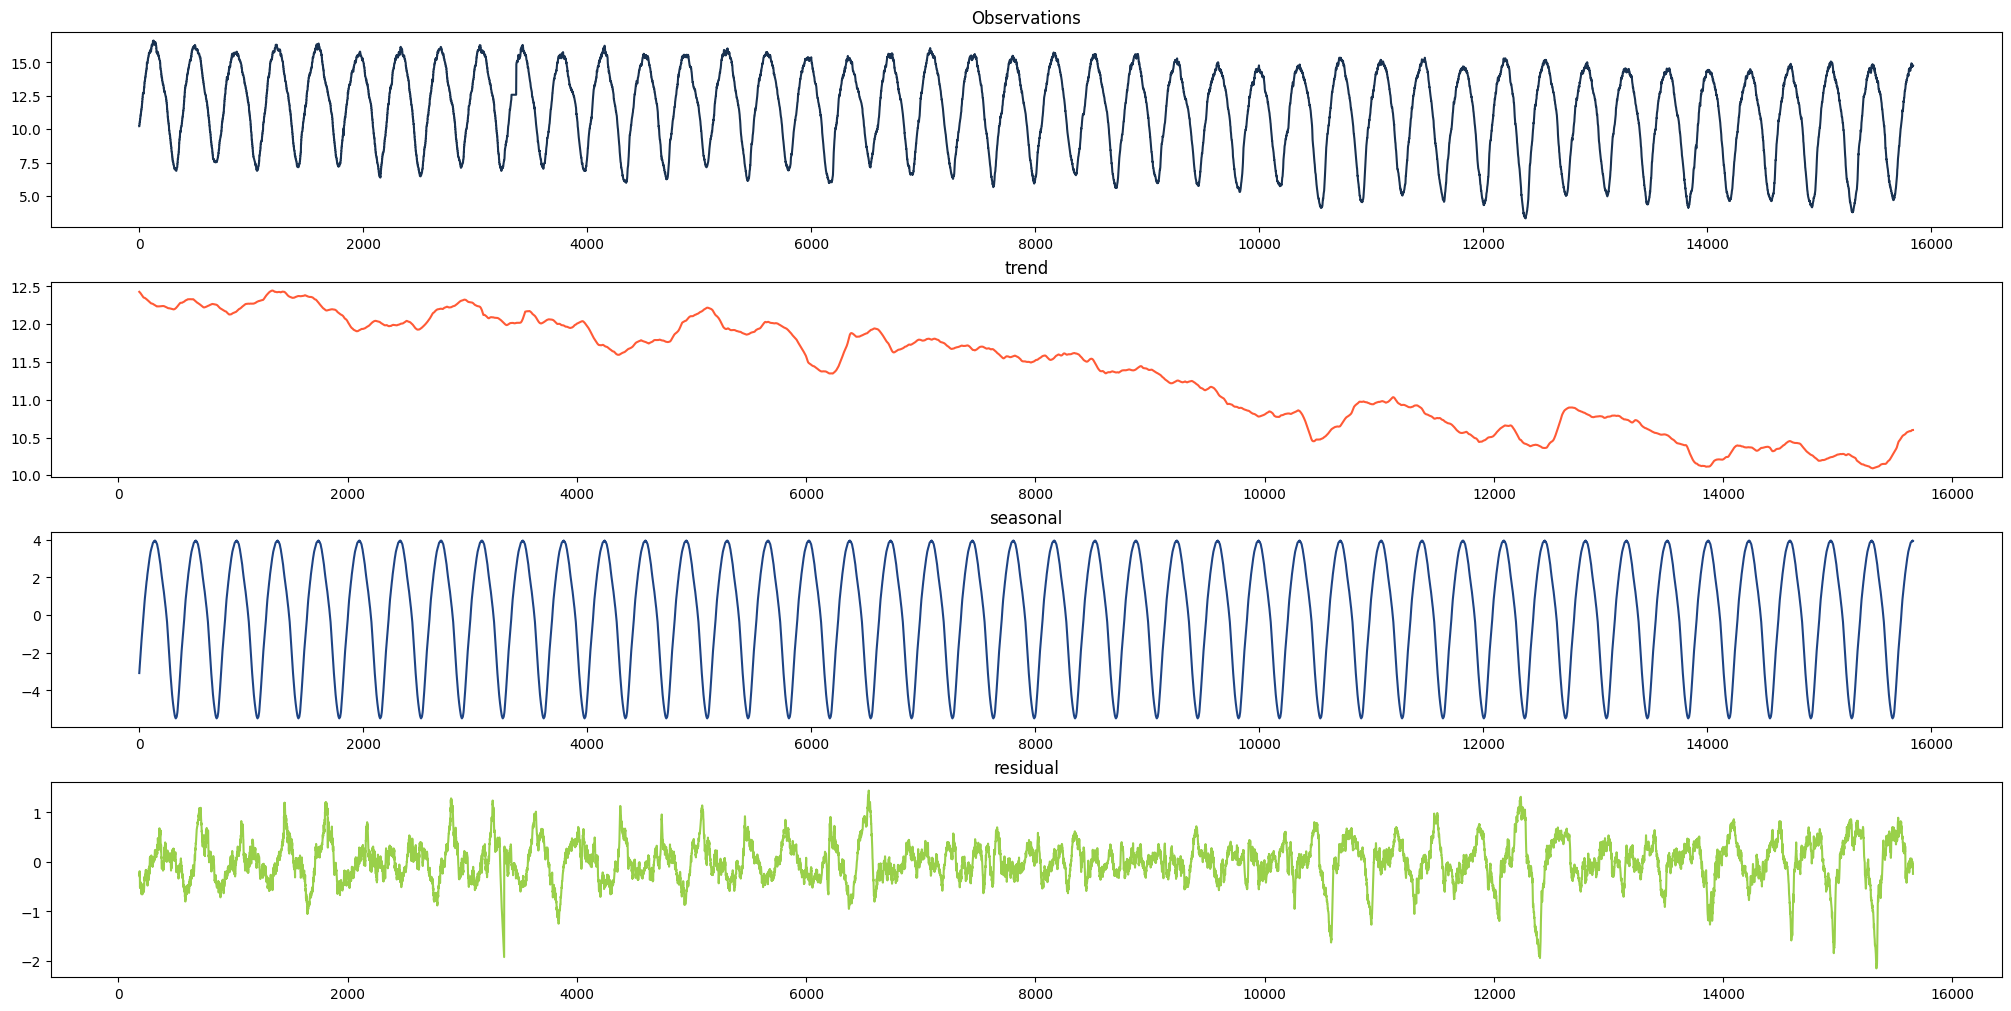

In [ ]:
# Check decomposition of trend, seasonality and residue of original time series
decomposition = seasonal_decompose(x=df_arima['y'], 
                                   model='additive',
                                   period=365)


fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='Observations')
decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')
fig.set_size_inches(20, 10);

## Check for Stationarity

In order to apply an **ARIMA** model on the data we have to check if the time series is stationary. If not, we have to make it stationary. 

**RECAP**: 
* *Stationarity*: A time series is stationary if its statistical properties (e.g. mean, variance, etc.) are the same throughout the series, independently of the point in time where you observe it. There are no long-term predictable patterns such as trend or seasonality. Plots will show a roughly horizontal trend with constant variance. 

In order to check for stationarity we will apply three different methods. First, we will calculate and plot the rolling mean and rolling standard deviation. It they show an upward or downward trend or vary over time, then it is highly likely that our time series is non-stationary. Furthermore, we will use the **ADF** (Augmented Dickey-Fuller) and the **KPSS** (Kwiatkowski-Phillips-Schmidt-Shintests) tests. We have to be careful when interpreting the results: the null-hypothesis of the ADF test is that the time series is non-stationary whereas the KPSS test assumes that it is stationary.

In [ ]:
df_arima

,ds,y
0,1978-10-26,10.231
1,1978-10-27,10.231
2,1978-10-28,10.420
3,1978-10-29,10.420
4,1978-10-30,10.557
...,...,...
15834,2022-03-03,14.703
15835,2022-03-04,14.748
15836,2022-03-05,14.762
15837,2022-03-06,14.756


ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -19.141962
p-value: 0.000000
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 1.759549
p-value: 0.010000
----------------------------------------


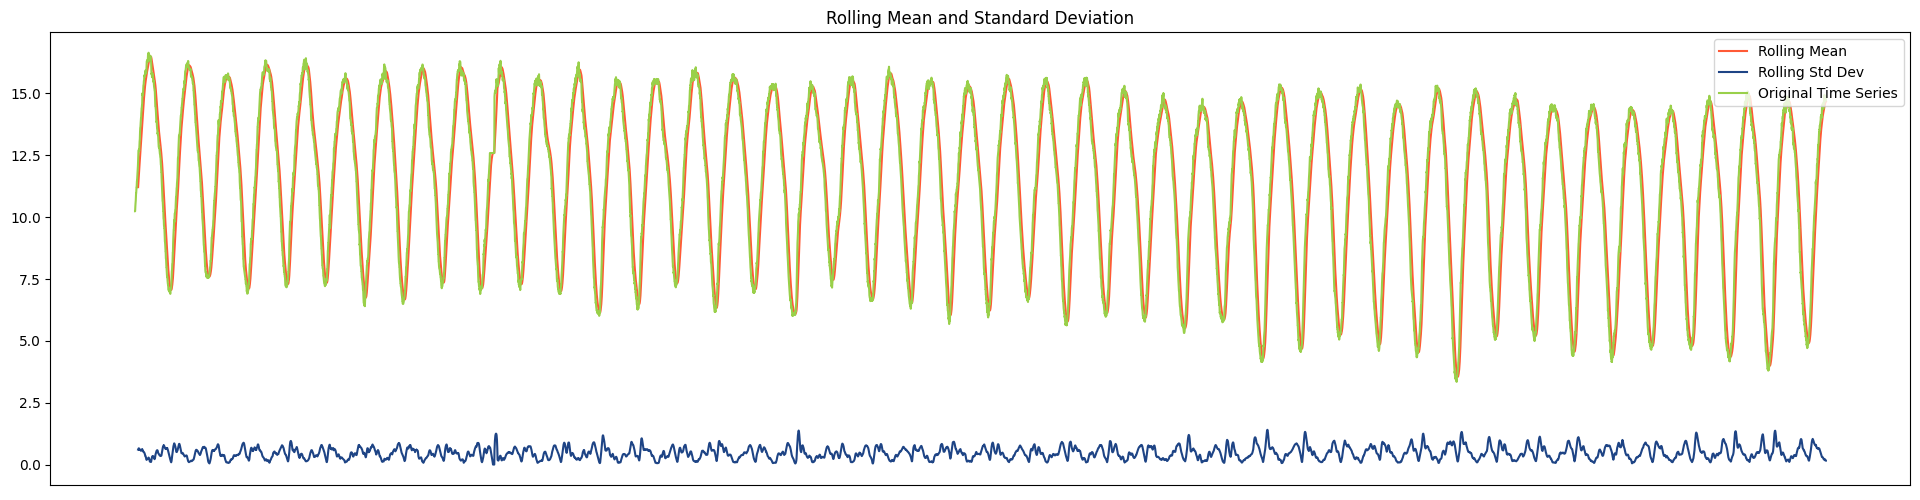

In [ ]:
# Test for stationarity 

def stationarity_test(stock_close_price):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = stock_close_price.rolling(30).mean()
    rolling_std_dev = stock_close_price.rolling(30).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(stock_close_price, color='#99D04A',label='Original Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(stock_close_price,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(stock_close_price, regression='c', nlags="legacy", store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
    
stationarity_test(df_arima['y'])

ADF >0,05 hyp False
KPSS <0,05 hyp False 
it is stationary

In [ ]:
# De-trending the time series
df_arima['y_detrend'] = (df_arima['y'] - df_arima['y'].shift(365))

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -10.041016
p-value: 0.000000
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 0.087508
p-value: 0.100000
----------------------------------------


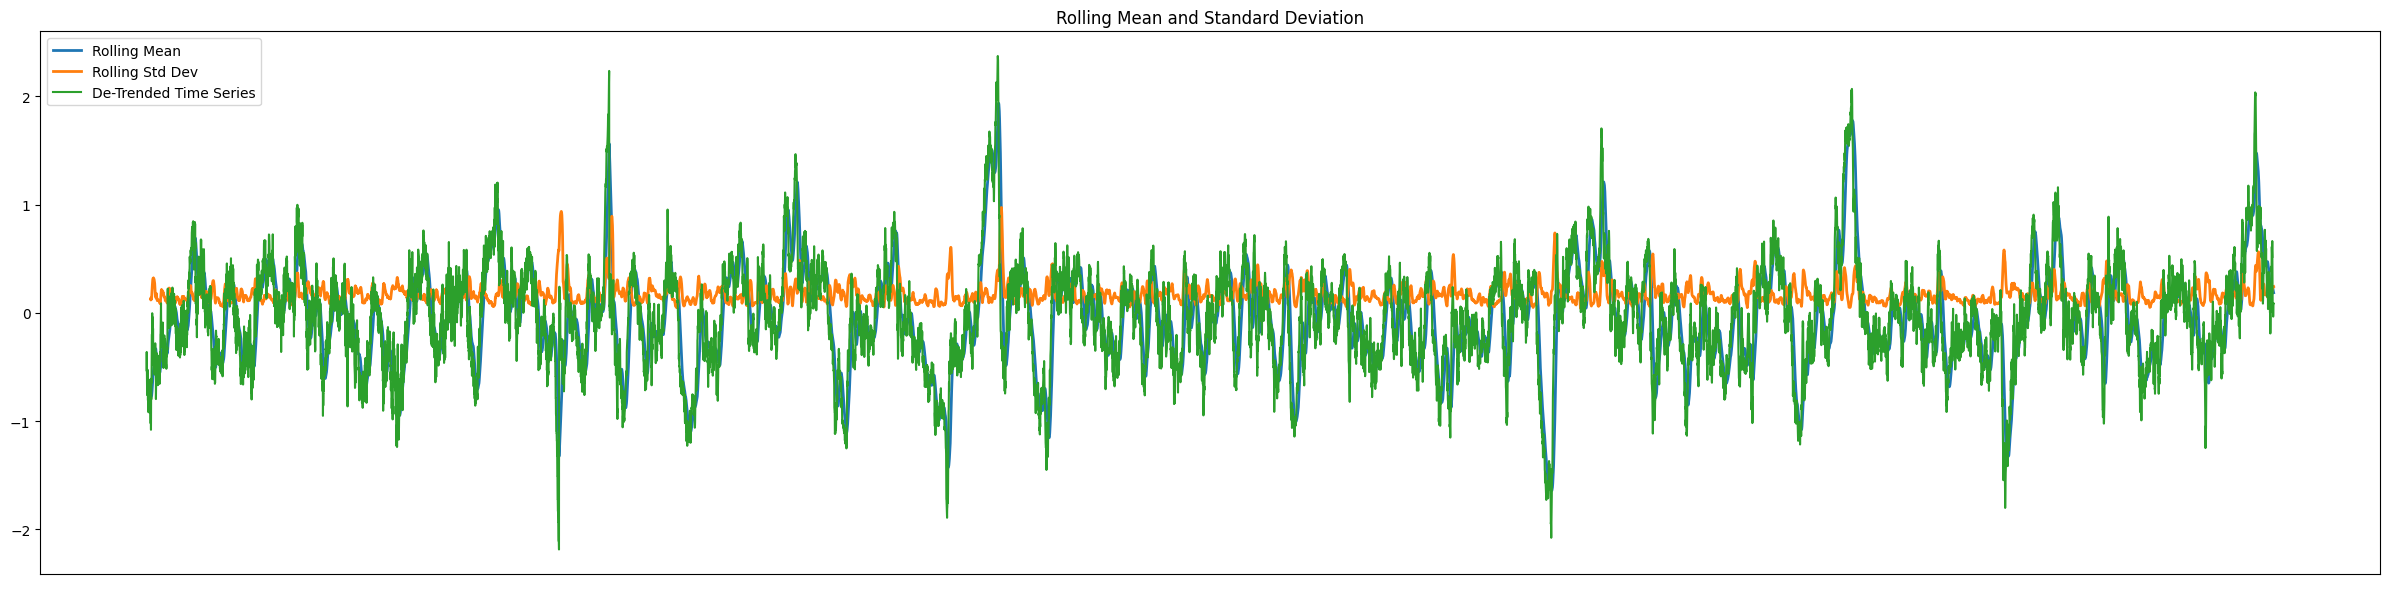

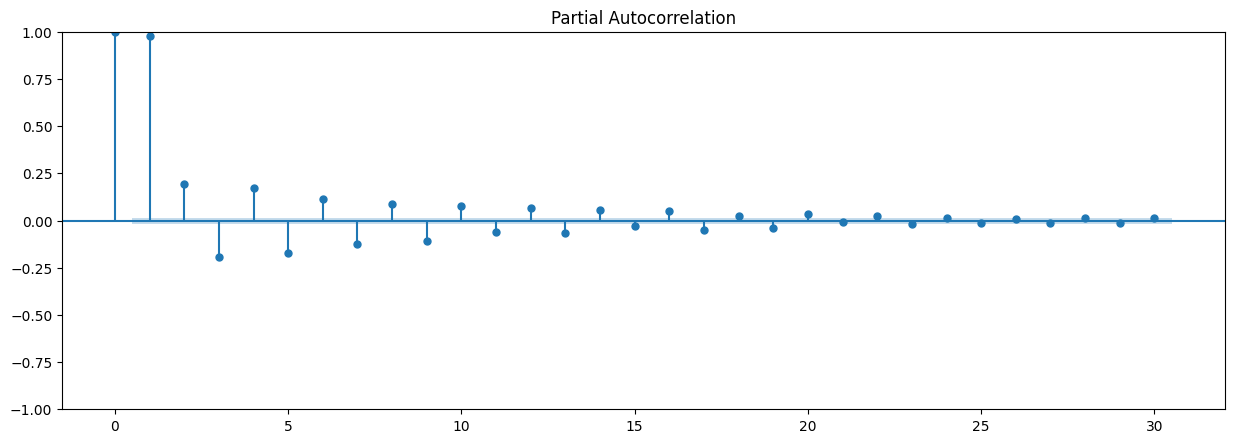

In [ ]:
# Test for stationarity after de-trending 
def stationarity_test(stock_close_price):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = stock_close_price.rolling(30).mean()
    rolling_std_dev = stock_close_price.rolling(30).std()
  
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, label='Rolling Mean',linewidth=2.0)
    plt.plot(rolling_std_dev, label = 'Rolling Std Dev',linewidth=2.0)
    plt.plot(stock_close_price,label='De-Trended Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.tight_layout()
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(stock_close_price,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(stock_close_price, regression='c', nlags='legacy', store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
    
stationarity_test(df_arima['y_detrend'].dropna())

# Partial Autocorrelation Plot
pacf = plot_pacf(df_arima['y_detrend'].dropna(), lags=30)